# Basics methods for training and prediction using Keras

In [1]:
from IPython.display import display, Markdown
with open('../../doc/env_variables_setup.md', 'r') as fh:
    content = fh.read()
display(Markdown(content))

Environment variables that need to be defined:   
`export DIR_PROJ=your_path_git_repository`  
`export PYTHONPATH=$DIR_PROJ/src`  
`export PATH_TENSORBOARD=your_path_tensorboard`  
`export PATH_DATASETS=your_path_datasets`  
`export PROJECT_ID=your_gcp_project_id`  
`export BUCKET_NAME=your_gcp_gs_bucket_name`  
`export REGION=your_region`  
`export MODEL_DIR_ESTIMATOR_PATH=your_path_to_save_model` 

- Use local Jupyter Lab 
    - you need to have the `jupyter-notebook` Anaconda python environment created [link](local_jupyter_lab_installation.md) 
    - you need to have the `jupyter-notebook` Anaconda python environment activated [link](local_jupyter_lab_installation.md) 
    - then define the environment variables above (copy and paste) 
    - you need to have the `env_multilingual_class` Anaconda python environment created [link](local_jupyter_lab_installation.md)  
    - start Jupyter Lab:  `jupyter lab` 
    - open a Jupyter Lab notebook from `notebook/` 
     - clone this repositiory: `git clone https://github.com/tarrade/proj_multilingual_text_classification.git`
    - choose the proper Anaconda python environment:  `Python [conda env:env_multilingual_class]` [link](conda_env.md) 
    - clone this repositiory: `git clone https://github.com/tarrade/proj_multilingual_text_classification.git`


- Use GCP Jupyter Lab 
    - Go on GCP
    - open a Cloud Shell
    - `ssh-keygen -t rsa -b 4096 -C firstName_lastName`
    - `cp .ssh/id_rsa.pub .`
    - use Cloud Editor to edit this file `id_rsa.pub` and copy the full content
    - Go on Compute Engine -> Metadata
    - Click SSH Keys
    - Click Edit
    - Click + Add item, copy the content of `id_rsa.pub`
    - You should see firstName_lastName of the left
    - Click Save
    - you need to start a AI Platform instance 
    - open a Jupyter Lab terminal and got to `/home/gcp_user_name/`
    - clone this repositiory: `git clone https://github.com/tarrade/proj_multilingual_text_classification.git`
    - then `cd proj_multilingual_text_classification/`
    - create the Anacond Python environment `conda env create -f env/environment.yml`
    - create a file `config.sh` in `/home` with the following information: 
    ```
    #!/bin/bash
    
    echo "applying some configuration ..."
    git config --global user.email user_email
    git config --global user.name user_name
    git config --global credential.helper store
        
    # Add here the enviroment variables from above below
    # [EDIT ME]
    export DIR_PROJ=your_path_git_repository
    export PYTHONPATH=$DIR_PROJ/src
  
    cd /home/gcp_user_name/
    
    conda activate env_multilingual_class

    export PS1='\[\e[91m\]\u@:\[\e[32m\]\w\[\e[0m\]$'
    ```
    - Got to AI Platform Notebook, select your instance and click "Reset".
    - Wait and reshreh you Web browser with the Notebook


## Import packages

In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.python.data.ops import dataset_ops
from absl import logging
import os
import numpy as np
import matplotlib.pyplot

## Define paths

In [3]:
try:
    data_dir=os.environ['PATH_DATASETS']
except:
    print('missing PATH_DATASETS')

# Import local packages

## Searching for Dataset

In [4]:
# see the list of available datasets from TF
tfds.list_builders()[0:10]

['abstract_reasoning',
 'aeslc',
 'aflw2k3d',
 'amazon_us_reviews',
 'arc',
 'bair_robot_pushing_small',
 'beans',
 'big_patent',
 'bigearthnet',
 'billsum']

In [5]:
# number of available datasets in TF
len(tfds.list_builders())

155

## Getting MNIST data

In [6]:
# Setup logging verbosity
logging.set_verbosity(logging.INFO)

### Load dataset

In [7]:
# loading an example dataset whilst storing info about it in ds_info
datasets, ds_info = tfds.load(name='mnist', with_info=True, as_supervised=True, data_dir=data_dir)

INFO:absl:Overwrite dataset info from restored data version.
INFO:absl:Field info.location from disk and from code do not match. Keeping the one from code.
INFO:absl:Reusing dataset mnist (/Users/tarrade/tensorflow_datasets/mnist/3.0.0)
INFO:absl:Constructing tf.data.Dataset for split None, from /Users/tarrade/tensorflow_datasets/mnist/3.0.0


### Get info about the dataset

In [8]:
ds_info

tfds.core.DatasetInfo(
    name='mnist',
    version=3.0.0,
    description='The MNIST database of handwritten digits.',
    homepage='http://yann.lecun.com/exdb/mnist/',
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    total_num_examples=70000,
    splits={
        'test': 10000,
        'train': 60000,
    },
    supervised_keys=('image', 'label'),
    citation="""@article{lecun2010mnist,
      title={MNIST handwritten digit database},
      author={LeCun, Yann and Cortes, Corinna and Burges, CJ},
      journal={ATT Labs [Online]. Available: http://yann. lecun. com/exdb/mnist},
      volume={2},
      year={2010}
    }""",
    redistribution_info=,
)

In [9]:
ds_info.name

'mnist'

In [10]:
ds_info.features

FeaturesDict({
    'image': Image(shape=(28, 28, 1), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
})

In [11]:
ds_info.features["label"].num_classes

10

In [12]:
ds_info.features["label"].names

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

In [13]:
ds_info.splits['train'].num_examples

60000

In [14]:
ds_info.splits['test'].num_examples

10000

In [15]:
ds_info.features

FeaturesDict({
    'image': Image(shape=(28, 28, 1), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
})

In [16]:
ds_info.features['label']

ClassLabel(shape=(), dtype=tf.int64, num_classes=10)

In [17]:
ds_info.splits['test']

<tfds.core.SplitInfo num_examples=10000>

In [18]:
ds_info.splits['train']

<tfds.core.SplitInfo num_examples=60000>

### Split train/test dataset

In [19]:
datasets

{'test': <DatasetV1Adapter shapes: ((28, 28, 1), ()), types: (tf.uint8, tf.int64)>,
 'train': <DatasetV1Adapter shapes: ((28, 28, 1), ()), types: (tf.uint8, tf.int64)>}

In [20]:
datasets.keys()

dict_keys(['test', 'train'])

In [21]:
mnist_train, mnist_test = datasets['train'], datasets['test']

### Check dimension and type of the data

In [22]:
datasets['train']

<DatasetV1Adapter shapes: ((28, 28, 1), ()), types: (tf.uint8, tf.int64)>

In [23]:
# old style
datasets['train'].output_shapes

Instructions for updating:
Use `tf.compat.v1.data.get_output_shapes(dataset)`.


Instructions for updating:
Use `tf.compat.v1.data.get_output_shapes(dataset)`.


(TensorShape([28, 28, 1]), TensorShape([]))

In [24]:
# old style
datasets['train'].output_types

Instructions for updating:
Use `tf.compat.v1.data.get_output_types(dataset)`.


Instructions for updating:
Use `tf.compat.v1.data.get_output_types(dataset)`.


(tf.uint8, tf.int64)

In [25]:
# old style
datasets['train'].output_classes

Instructions for updating:
Use `tf.compat.v1.data.get_output_classes(dataset)`.


Instructions for updating:
Use `tf.compat.v1.data.get_output_classes(dataset)`.


(tensorflow.python.framework.ops.Tensor,
 tensorflow.python.framework.ops.Tensor)

In [26]:
# new way
dataset_ops.get_legacy_output_shapes(datasets['train'])

(TensorShape([28, 28, 1]), TensorShape([]))

In [27]:
# new way
dataset_ops.get_legacy_output_types(datasets['train'])

(tf.uint8, tf.int64)

In [28]:
# new way
dataset_ops.get_legacy_output_classes(datasets['train'])

(tensorflow.python.framework.ops.Tensor,
 tensorflow.python.framework.ops.Tensor)

### Check data

In [29]:
# tensorflow object
for l in datasets['train']:
    print(l)
    break

(<tf.Tensor: shape=(28, 28, 1), dtype=uint8, numpy=
array([[[  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0]],

       [[  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0]],

       [[  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],

In [30]:
# get numpy array
for element in datasets['train'].as_numpy_iterator(): 
    print(element) 
    break

(array([[[  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0]],

       [[  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0]],

       [[  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
     

In [31]:
# number of observations and labels
np.shape(list(datasets['train'].as_numpy_iterator()))

(60000, 2)

In [32]:
np.shape(list(datasets['train'].take(1).as_numpy_iterator())[0])

(2,)

In [33]:
# size of the picture (28x28) and the index for colour dimension (1=greyscale)
(list(datasets['train'].take(1).as_numpy_iterator())[0][0]).shape

(28, 28, 1)

In [34]:
# data type of the shape (?)
(list(datasets['train'].take(1).as_numpy_iterator())[0][0]).dtype

dtype('uint8')

In [35]:
(list(datasets['train'].take(1).as_numpy_iterator())[0][1]).shape

()

In [36]:
(list(datasets['train'].take(1).as_numpy_iterator())[0][1]).dtype

dtype('int64')

## Preparing and preprocessing the data

### use tf.data to prepare and preprocess the data

In [37]:
def scale(image, label):
    image = tf.cast(image, tf.float32)
    image /= 255
    
    return image, label

In [38]:
# Define the model's hyperparameters
STEPS_PER_EPOCH = 6
BUFFER_SIZE = 10000
BATCH_SIZE = 500
NUM_EPOCHS = 25

In [39]:
# repeat the training set
train_data = mnist_train.repeat().map(scale).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
# take the test set once
test_data = mnist_test.map(scale).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

### check the final dataset

In [40]:
# test dataset: 10'000 entries
# each batch of data contains N example of data with N:
10000/BATCH_SIZE

20.0

In [41]:
len(list(test_data.as_numpy_iterator()))

20

In [42]:
# shape is enhanced by the size of the batches
(list(test_data.as_numpy_iterator())[0][0]).shape

(500, 28, 28, 1)

In [43]:
(list(test_data.as_numpy_iterator())[0][0]).dtype

dtype('float32')

In [44]:
# size of the batch is now the new first entry
(list(test_data.as_numpy_iterator())[0][1]).shape

(500,)

In [45]:
(list(test_data.as_numpy_iterator())[0][1]).dtype

dtype('int64')

In [46]:
import matplotlib.pyplot

INFO:absl:Overwrite dataset info from restored data version.
INFO:absl:Field info.location from disk and from code do not match. Keeping the one from code.
INFO:absl:Reusing dataset mnist (/Users/tarrade/tensorflow_datasets/mnist/3.0.0)
INFO:absl:Constructing tf.data.Dataset for split test, from /Users/tarrade/tensorflow_datasets/mnist/3.0.0


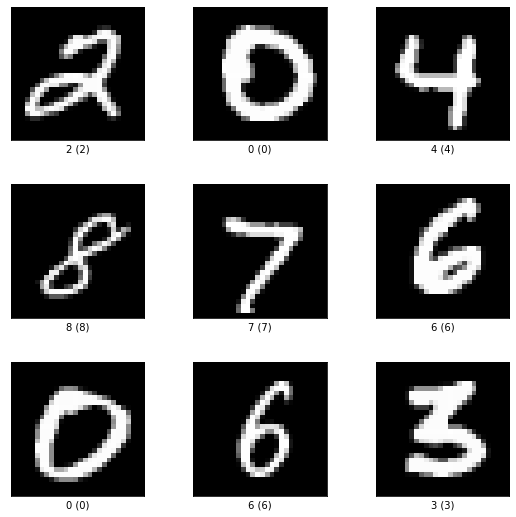

In [47]:
ds_test, ds_test_info = tfds.load("mnist", split="test", with_info=True)
# specific to a picture dataset
fig = tfds.show_examples(ds_test_info, ds_test)

## Getting Microsoft Research Paraphrase Corpus (MRPC) data

In [48]:
data, info = tfds.load('glue/mrpc', with_info=True,)

INFO:absl:Overwrite dataset info from restored data version.
INFO:absl:Reusing dataset glue (/Users/tarrade/tensorflow_datasets/glue/mrpc/1.0.0)
INFO:absl:Constructing tf.data.Dataset for split None, from /Users/tarrade/tensorflow_datasets/glue/mrpc/1.0.0


In [49]:
data.keys()

dict_keys(['test', 'train', 'validation'])

In [50]:
data['train']

<DatasetV1Adapter shapes: {idx: (), label: (), sentence1: (), sentence2: ()}, types: {idx: tf.int32, label: tf.int64, sentence1: tf.string, sentence2: tf.string}>

In [51]:
dataset_ops.get_legacy_output_shapes(data['train'])

{'idx': TensorShape([]),
 'label': TensorShape([]),
 'sentence1': TensorShape([]),
 'sentence2': TensorShape([])}

In [52]:
dataset_ops.get_legacy_output_types(data['train'])

{'idx': tf.int32,
 'label': tf.int64,
 'sentence1': tf.string,
 'sentence2': tf.string}

In [53]:
dataset_ops.get_legacy_output_classes(data['train'])

{'idx': tensorflow.python.framework.ops.Tensor,
 'label': tensorflow.python.framework.ops.Tensor,
 'sentence1': tensorflow.python.framework.ops.Tensor,
 'sentence2': tensorflow.python.framework.ops.Tensor}

In [54]:
for l in data['train']:
    print(l.keys())
    print(l)
    print(l['idx'])
    print(l['label'])
    print(l['sentence1'])
    break

dict_keys(['idx', 'label', 'sentence1', 'sentence2'])
{'idx': <tf.Tensor: shape=(), dtype=int32, numpy=1680>, 'label': <tf.Tensor: shape=(), dtype=int64, numpy=0>, 'sentence1': <tf.Tensor: shape=(), dtype=string, numpy=b'The identical rovers will act as robotic geologists , searching for evidence of past water .'>, 'sentence2': <tf.Tensor: shape=(), dtype=string, numpy=b'The rovers act as robotic geologists , moving on six wheels .'>}
tf.Tensor(1680, shape=(), dtype=int32)
tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(b'The identical rovers will act as robotic geologists , searching for evidence of past water .', shape=(), dtype=string)


In [55]:
# get numpy array
for element in data['train'].as_numpy_iterator(): 
    print(element) 
    break

{'idx': 1680, 'label': 0, 'sentence1': b'The identical rovers will act as robotic geologists , searching for evidence of past water .', 'sentence2': b'The rovers act as robotic geologists , moving on six wheels .'}


In [56]:
# take the first three entries
# Note: this approach does not work when creating batches with iter(x.batch())
list(data['train'].take(3).as_numpy_iterator())

[{'idx': 1680,
  'label': 0,
  'sentence1': b'The identical rovers will act as robotic geologists , searching for evidence of past water .',
  'sentence2': b'The rovers act as robotic geologists , moving on six wheels .'},
 {'idx': 1456,
  'label': 0,
  'sentence1': b"Less than 20 percent of Boise 's sales would come from making lumber and paper after the OfficeMax purchase is completed .",
  'sentence2': b"Less than 20 percent of Boise 's sales would come from making lumber and paper after the OfficeMax purchase is complete , assuming those businesses aren 't sold ."},
 {'idx': 3017,
  'label': 1,
  'sentence1': b'Spider-Man snatched $ 114.7 million in its debut last year and went on to capture $ 403.7 million .',
  'sentence2': b'Spider-Man , rated PG-13 , snatched $ 114.7 million in its first weekend and went on to take in $ 403.7 million .'}]

In [57]:
# number of entries in the training dataset
np.shape(list(data['train'].as_numpy_iterator()))

(3668,)

In [58]:
list(data['train'].take(3).as_numpy_iterator())[0]

{'idx': 1680,
 'label': 0,
 'sentence1': b'The identical rovers will act as robotic geologists , searching for evidence of past water .',
 'sentence2': b'The rovers act as robotic geologists , moving on six wheels .'}

In [59]:
# id of the third entry
list(data['train'].take(3).as_numpy_iterator())[0]['idx']

1680

In [60]:
# label of the third entry 
list(data['train'].take(3).as_numpy_iterator())[0]['label']

0

In [61]:
list(data['train'].take(3).as_numpy_iterator())[0]['sentence1']

b'The identical rovers will act as robotic geologists , searching for evidence of past water .'

In [62]:
list(data['train'].take(3).as_numpy_iterator())[0]['sentence2']

b'The rovers act as robotic geologists , moving on six wheels .'

In [63]:
info

tfds.core.DatasetInfo(
    name='glue',
    version=1.0.0,
    description='GLUE, the General Language Understanding Evaluation benchmark
(https://gluebenchmark.com/) is a collection of resources for training,
evaluating, and analyzing natural language understanding systems.

            The Microsoft Research Paraphrase Corpus (Dolan & Brockett, 2005) is a corpus of
            sentence pairs automatically extracted from online news sources, with human annotations
            for whether the sentences in the pair are semantically equivalent.',
    homepage='https://www.microsoft.com/en-us/download/details.aspx?id=52398',
    features=FeaturesDict({
        'idx': tf.int32,
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
        'sentence1': Text(shape=(), dtype=tf.string),
        'sentence2': Text(shape=(), dtype=tf.string),
    }),
    total_num_examples=5801,
    splits={
        'test': 1725,
        'train': 3668,
        'validation': 408,
    },
    superv

In [64]:
info.features

FeaturesDict({
    'idx': tf.int32,
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    'sentence1': Text(shape=(), dtype=tf.string),
    'sentence2': Text(shape=(), dtype=tf.string),
})

In [65]:
info.features["label"].names

['not_equivalent', 'equivalent']

In [66]:
info.features["label"].num_classes

2

In [67]:
info.splits

{'test': <tfds.core.SplitInfo num_examples=1725>,
 'train': <tfds.core.SplitInfo num_examples=3668>,
 'validation': <tfds.core.SplitInfo num_examples=408>}

In [68]:
info.splits['test'].get_proto()

name: "test"
num_shards: 1
statistics {
  num_examples: 1725
  features {
    name: "idx"
    num_stats {
      common_stats {
        num_non_missing: 1725
      }
      max: 1724.0
    }
  }
  features {
    name: "label"
    num_stats {
      common_stats {
        num_non_missing: 1725
      }
      min: -1.0
      max: -1.0
    }
  }
  features {
    name: "sentence1"
    type: BYTES
    bytes_stats {
      common_stats {
        num_non_missing: 1725
      }
    }
  }
  features {
    name: "sentence2"
    type: BYTES
    bytes_stats {
      common_stats {
        num_non_missing: 1725
      }
    }
  }
}
shard_lengths: 1725

In [69]:
test=tfds.as_numpy(data['test'].take(2))

In [70]:
# be careful, it seems that the content is gone after executing one operation !
list(test)[0].keys()

dict_keys(['idx', 'label', 'sentence1', 'sentence2'])